<br>

<br>

<br> 


<img src= "https://img.favpng.com/18/23/16/computer-icons-missing-data-ibm-data-science-experience-png-favpng-dKXSj5SMn0HT0tcGj9EvcZXsM.jpg" 
     class="centerImage" 
     alt ="missindata" 
     style="width: 900px; height: 300px" >

### Small Intro
<br>

Missing data, is probably the first horror movie that you can watch when exploring your dataset, depending on the volume of missingness, and nature of variables you can try some good techniques with no guarantee of getting bias-free results, but in general, time series are known to be way more hard to handle and not all methods are applicable on them. In this notebook, we'll try to discover together what are the best techniques to impute holes in time series and what are techniques that you should never use.

###  About dataset

To get the most out of this notebook, i have chosen the "Aquifer_Auser dataset" available in this [competition data page](https://www.kaggle.com/c/acea-water-prediction/data), it suffers from several anomalies(outliers, non stationnarity, huge percentage of missing values... etc), which will allow the use of a multitude of statistical analysis techniques, including hypothesis tests, arima, exponential smoothing... .




So, Let's begin!

In [1]:
# ↧↧ some necessary imports

import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 

from statsmodels.tsa.holtwinters import ExponentialSmoothing 
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import pacf, adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA 
import statsmodels.api as sm
from datetime import date
from pandas.tseries.offsets import DateOffset as dateoffset
from tqdm.notebook import tqdm



import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
warnings.filterwarnings('ignore')


# 1. Exploratory Analysis 👀

In [2]:
filepath='/kaggle/input/acea-water-prediction/Aquifer_Auser.csv'
auser=pd.read_csv(filepath)
auser.head()  

,Date,Rainfall_Gallicano,Rainfall_Pontetetto,Rainfall_Monte_Serra,Rainfall_Orentano,Rainfall_Borgo_a_Mozzano,Rainfall_Piaggione,Rainfall_Calavorno,Rainfall_Croce_Arcana,Rainfall_Tereglio_Coreglia_Antelminelli,...,Temperature_Monte_Serra,Temperature_Ponte_a_Moriano,Temperature_Lucca_Orto_Botanico,Volume_POL,Volume_CC1,Volume_CC2,Volume_CSA,Volume_CSAL,Hydrometry_Monte_S_Quirico,Hydrometry_Piaggione
0,05/03/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06/03/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,10.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,07/03/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.2,0.0,10.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,08/03/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.4,0.0,13.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,09/03/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.4,0.0,12.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> What is the data type of each column?

In [3]:
auser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8154 entries, 0 to 8153
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Date                                     8154 non-null   object 
 1   Rainfall_Gallicano                       5295 non-null   float64
 2   Rainfall_Pontetetto                      5295 non-null   float64
 3   Rainfall_Monte_Serra                     5289 non-null   float64
 4   Rainfall_Orentano                        5295 non-null   float64
 5   Rainfall_Borgo_a_Mozzano                 5295 non-null   float64
 6   Rainfall_Piaggione                       4930 non-null   float64
 7   Rainfall_Calavorno                       5295 non-null   float64
 8   Rainfall_Croce_Arcana                    5295 non-null   float64
 9   Rainfall_Tereglio_Coreglia_Antelminelli  5295 non-null   float64
 10  Rainfall_Fabbriche_di_Vallico            5295 no

> First thing we should do is to convert "Date" column to datetime object, and (optionally) convert other columns to float32 to avoid any oom errors in case you intend to use the dataset as an entry of a prediction model.

In [4]:
auser.Date=pd.to_datetime(auser.Date,dayfirst=True)
#auser.iloc[:,1:]=auser.iloc[:,1:].astype('float32')

## 1.1 Missing values Detection 🔍

>  What percentage of missing values do we have in each column ?

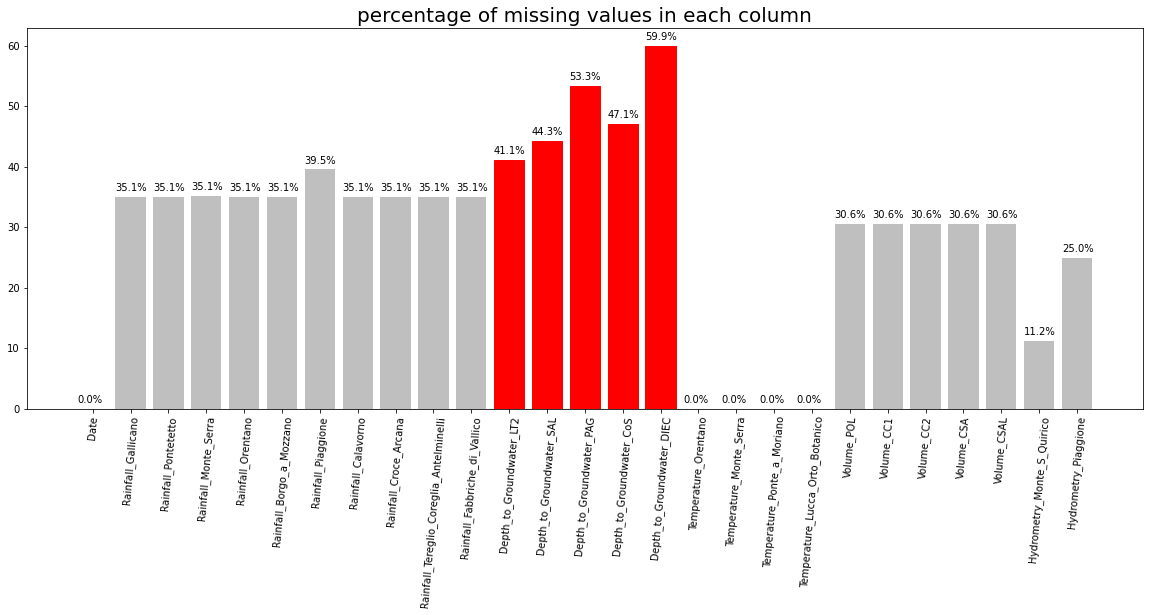

In [5]:
missing_ratio=auser.isna().sum()*100/len(auser)
critical=[]
plt.figure(figsize=(20,7))
plt.xticks(rotation=85)
for i,v in enumerate(missing_ratio):
    plt.text(i-0.4,v+0.99,"%.1f" % v +'%')
    if v>40:
        critical.append(i)
barlist=plt.bar(auser.columns,missing_ratio,color='0.75')
for e in critical:
    barlist[e].set_color('red')
plt.title('percentage of missing values in each column',fontdict={'fontsize':20})
plt.show()


> We can use another interesting graph from missingno package, it converts the dataframe columns to uniformly stacked bars, and represents missing observations using white lines

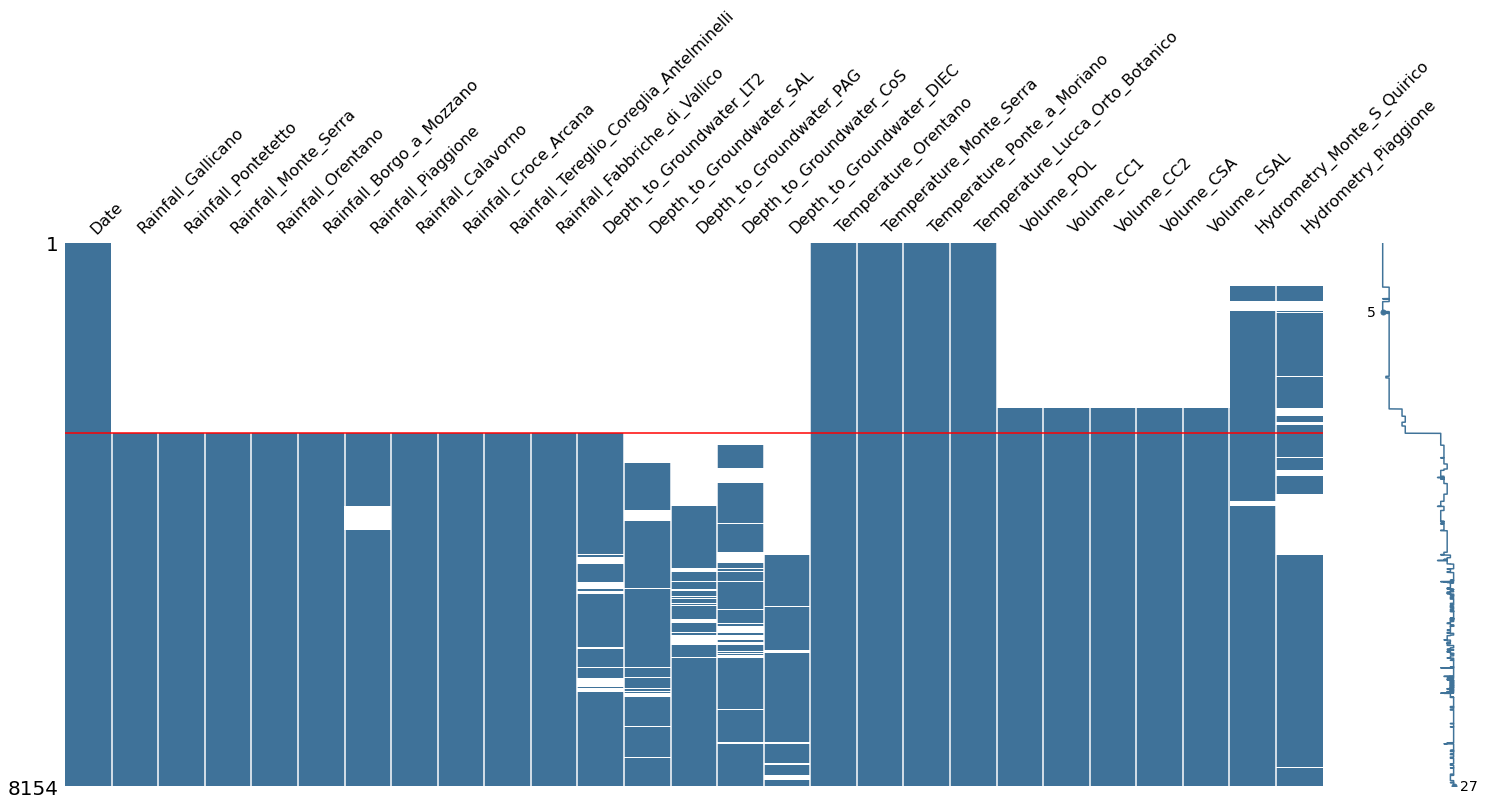

In [6]:
import missingno as msno
miss=msno.matrix(auser,color=(0.25, 0.45, 0.6))
miss.axhline(y=auser.Rainfall_Gallicano.first_valid_index(),color="red")
plt.show()

An important question should come to mind here, is what's the mechanism of missingness ? is it random (MAR), completely at random (MCAR), or not at random (MNAR)?

brief explanation for those having no idea what it is:
> **MCAR** : when each observation have the same chance to be lost, it's the case when data is deleted by error, or not recorded by error. In this situation we can delete these observations if the percentage is low enough, but generally it's preferable to proceed with imputation technique(with mode, mean...), or interpolation for time series. Another appreciated technique if the percentage is high is prediction using machine learning models, the challenge here is to find the right features to be used as predictors, but if data is already anonymized, just forget about it.

> **MAR** : when the missingness is related to one or more observed variable in the data set, for example, "salary" variable has missing values for people having "age" variable <16 years. This mechanism share the same filling techniques with MCAR, except deleting, it's not allowed to delete any data here because it affect the data distribution and any further analysis based on that will be biased.

> **MNAR** : when the missingness is related to the variable itself, for example when  "weight" variable has missing values because concerned people are too obese and don't want to reveale their real weight. 
This is the hardest one and fortunately the rarest, cause here we can't use simple imputation techniques (imagine you want to impute using the mean, and the average of weights is 73kg, an obese person has clearly more than 100 kg,  this wrong estimation will generate biased and non consistent results), the best way to deal with is prediction techniques if possible.

In most cases and when we don't know how data have been collected, it's very hard to figure out the mechanism. But going back to literature, we can easily find tons of climate and hydrometeorological studies, in which the presence of missing data is almost a usual thing, and mostly caused by external factors (sensors defection, incorrect measurement, instrument malfunction...etc), thus, we assume that our missing data is MCAR.


Another probably missing data can come out from outliers or invalid values. Boxplot is a very good statistical graph that gives you a good indication of how the values are spread out, about distribution and especially the existence of invalid values.

here is how the box plot looks like:

<img src= "https://miro.medium.com/max/18000/1*2c21SkzJMf3frPXPAR_gZA.png" alt ="boxplot" style='width: 900px;'>

* The quantile $Qi$ is the obsevation that splits dataset into  $(25 * i)\% $ and $(100-25 * i)\% $ . Median= $Q2$  and $IQR = Q3 - Q1$ 

* Outliers are the observations that came beyond the extremity=$Qj \pm 1.5IQR$  $\;\;\;\;\;\;$  $j=1,3$

Let's see what we'll get from our data

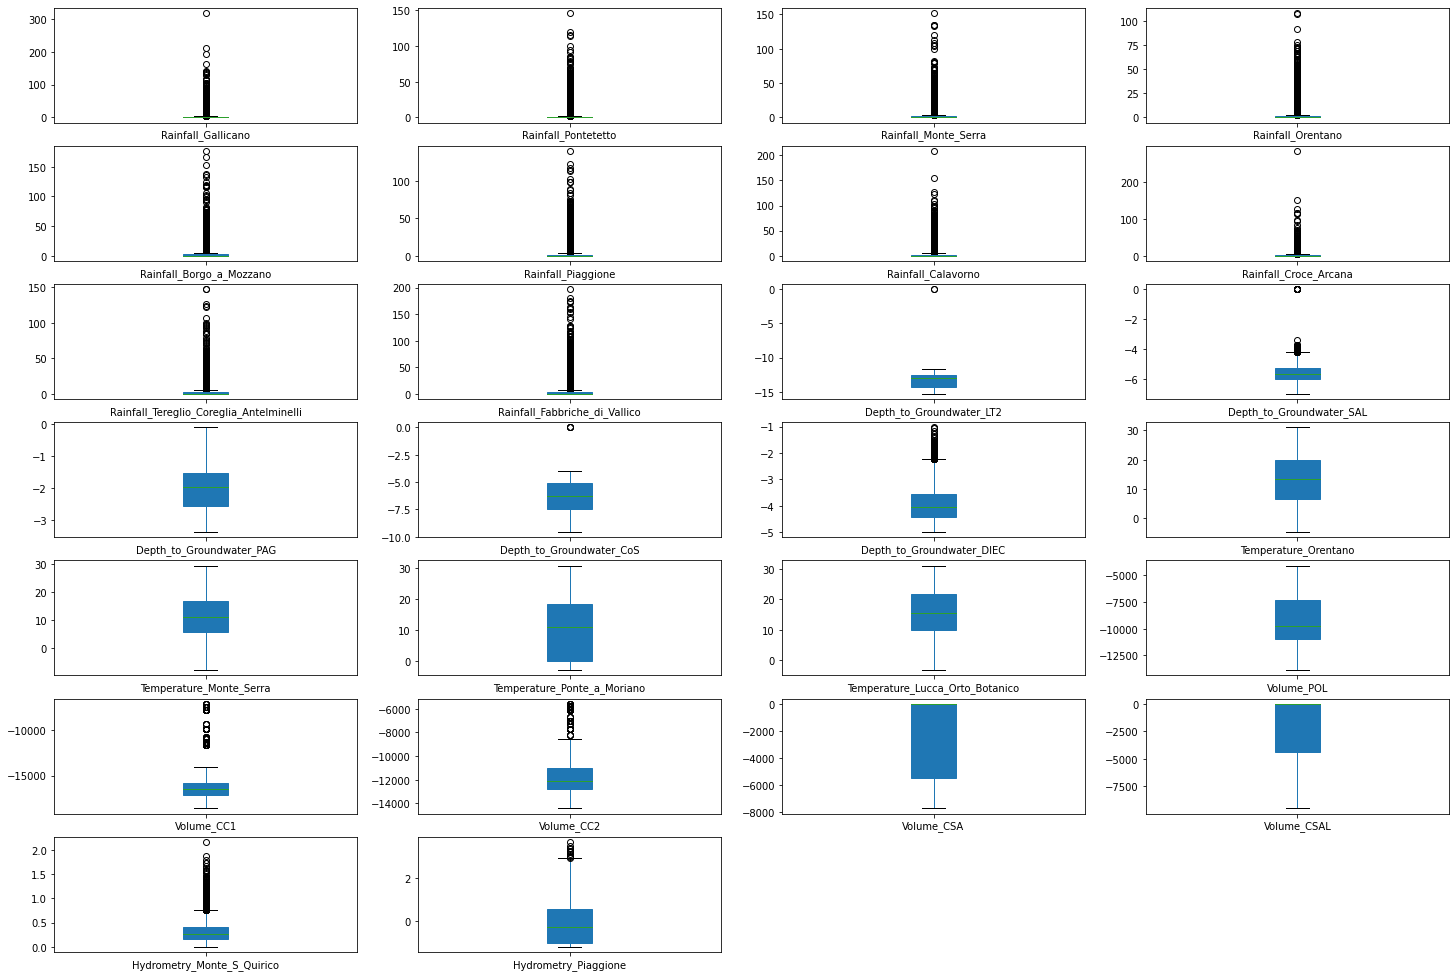

In [7]:
auser.plot(subplots=True,kind='box',layout=(10,4),legend=False,figsize=(25,25),patch_artist=True)
plt.show()

* we notice that "Depth_to_Groundwater_LT2, Depth_to_Groundwater_SAL, Depth_to_Groundwater_CoS" have some null values which are pretty far from the rest of observations and according to the data description in the competition webpage those variable should always be negative. let's see how many they are to make a safe judgement



In [8]:
for e in ["Depth_to_Groundwater_LT2","Depth_to_Groundwater_SAL","Depth_to_Groundwater_CoS"]:
    print(auser[e][auser[e]==0].value_counts().item())


2
10
4


In [9]:
#not too much so we can replace null value with nan value
for e in ["Depth_to_Groundwater_LT2","Depth_to_Groundwater_SAL","Depth_to_Groundwater_CoS"]:
    auser[e].replace(0,np.nan,inplace=True)

* the boxplots show that in "Volume_CSA" and "Volume_CSAl" variables, the half of valid observations are null which is not realistic, let's investigate more

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

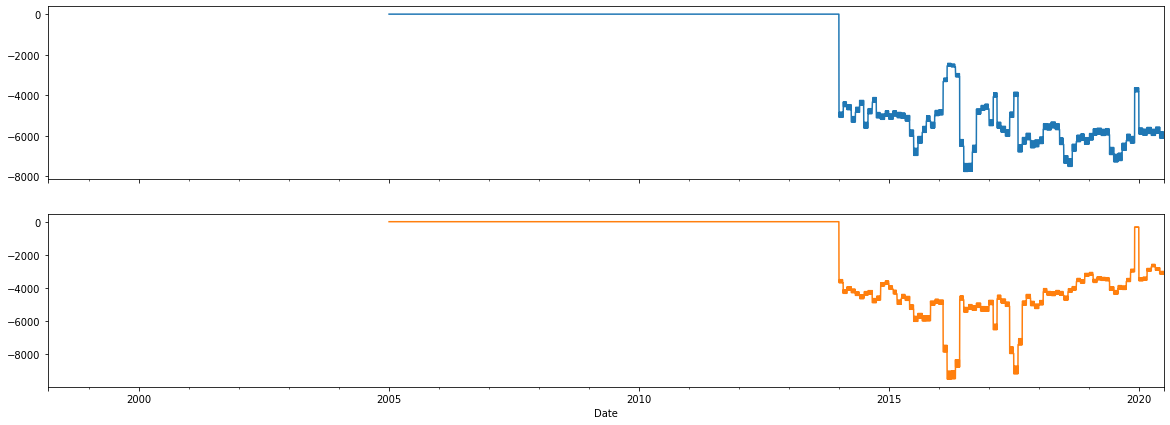

In [10]:
auser.plot(x='Date',y=['Volume_CSA','Volume_CSAL'],subplots=True,figsize=(20,7),legend=False)

these two variables suffer from severe missingness, the straight line showing null value for the same period for both of them indicates a systematic data entry error, the total percentage of missing values reaches 70%, and the data show no pattern to track, which make the use of these two variables for futur analysis impossible.

In [11]:
for e in ['Volume_CSAL','Volume_CSA']:
    auser[e].replace(0,np.nan,inplace=True)
    percent=auser[e].isna().sum()/len(auser)
    print( "%.2f" % (percent*100)  + "% of data are missing in "+e)


70.90% of data are missing in Volume_CSAL
70.90% of data are missing in Volume_CSA


Hence we'll drop out these two variables as well as the first part of the dataset suffering from massive losses (before the red line in missingno plot), data after the red line will benefit from imputing/prediction techniques.

In [12]:
auser=auser.iloc[auser.Rainfall_Gallicano.first_valid_index():]
auser.reset_index(drop=True,inplace=True)
auser.drop(['Volume_CSA','Volume_CSAL'],inplace=True,axis=1)

For the other variables, we can't really judge about the existence of invalid values just only from boxplots, we may need to take a close look at each 

<br>





<br>


## 1.2 Missing values treatment 🩹

> Check first if there are missing dates, if no date is missing the following code return True

In [13]:
auser.set_index('Date',inplace=True)
(pd.date_range(start=date(2006,1,1),end=date(2020,6,30))==auser.index).all()

True


> Fortunately, no date is missing, now we will go through columns with missing values one by one and try to use the best technique to fill in holes.

In [14]:
auser.isna().any()

Rainfall_Gallicano                         False
Rainfall_Pontetetto                        False
Rainfall_Monte_Serra                        True
Rainfall_Orentano                          False
Rainfall_Borgo_a_Mozzano                   False
Rainfall_Piaggione                          True
Rainfall_Calavorno                         False
Rainfall_Croce_Arcana                      False
Rainfall_Tereglio_Coreglia_Antelminelli    False
Rainfall_Fabbriche_di_Vallico              False
Depth_to_Groundwater_LT2                    True
Depth_to_Groundwater_SAL                    True
Depth_to_Groundwater_PAG                    True
Depth_to_Groundwater_CoS                    True
Depth_to_Groundwater_DIEC                   True
Temperature_Orentano                       False
Temperature_Monte_Serra                    False
Temperature_Ponte_a_Moriano                False
Temperature_Lucca_Orto_Botanico            False
Volume_POL                                 False
Volume_CC1          

> ### **VAR1** : Rainfall_Monte_Serra 

In [15]:
auser.Rainfall_Monte_Serra.isna().sum()

6

<AxesSubplot:xlabel='Date'>

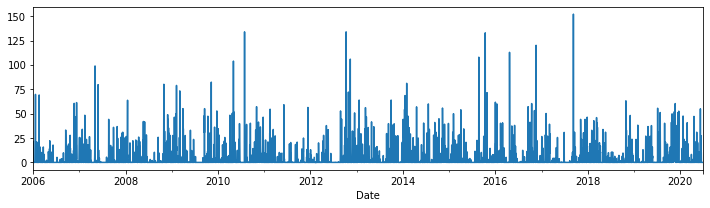

In [16]:
auser.Rainfall_Monte_Serra.plot(figsize=(12,3))

6 missing values, given the nature of the variable, 0 is the most common value, and the best value to fill in with in this case.


In [17]:
auser.Rainfall_Monte_Serra.fillna(0,inplace=True)

> ### **VAR2** : Rainfall_Piaggione

<AxesSubplot:title={'center':'daily rainfall'}, xlabel='Date'>

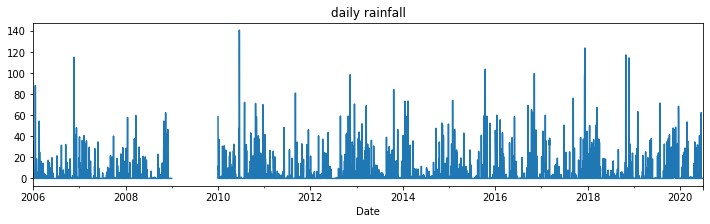

In [18]:
auser.Rainfall_Piaggione.plot(figsize=(12,3),title='daily rainfall')

In [19]:
auser.Rainfall_Piaggione.isna().sum()

365

one year of missing values=365 days, the first idea coming to mind here is to train an ARIMA model on the second part (2010-2020) and try to predict the missing values using the first part (2006-2008), but if you have worked with rainfall data before, you probably know that it's so hard to modelize and a simple ARIMA model won't find the real pattern behind because the processus is more prone to randomness and needs accurate explanatory variables to be well estimated.

that said, let's give it a try to be certain.


In [20]:
#  check stationarity first
def isstationary(data):
    adf=adfuller(data,regression='ct')
    print('****** ADfuller test ****** ' )
    if adf[1]>0.05:
        print(f'pvalue = {adf[1]} , we can not reject H0, so the data has unit root and it\'s not trend stationary')
    else:
        print(f'pvalue = {adf[1]} , we reject H0, data has no unit root')
    print('\n')

    
    kps=kpss(data, regression="ct")
    print('****** KPSS test ****** ' )
    if kps[1]>0.05:
        print(f'pvalue = {kps[1]} , we can not reject H0,  the data is trend stationary')
    else:
        print(f'pvalue = {kps[1]} , we reject H0, data is not trend stationary')

In [21]:
lastnan = auser.query('Rainfall_Piaggione!=Rainfall_Piaggione').index.tolist()[-1]
isstationary(auser.Rainfall_Piaggione.loc[lastnan+dateoffset(1):])

****** ADfuller test ****** 
pvalue = 1.0112262119740051e-19 , we reject H0, data has no unit root


****** KPSS test ****** 
pvalue = 0.1 , we can not reject H0,  the data is trend stationary


Now let's plot the autocorrelation graphs


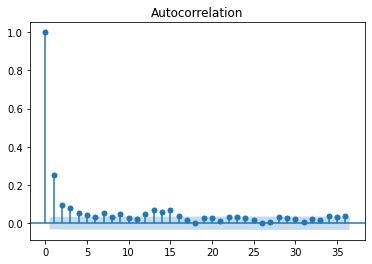

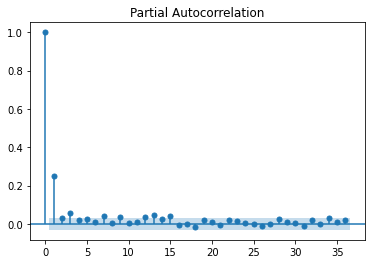

In [22]:
fig1=plot_acf(auser.Rainfall_Piaggione.loc[lastnan+dateoffset(1):])
fig2=plot_pacf(auser.Rainfall_Piaggione.loc[lastnan+dateoffset(1):])


the PACF is showing an AR(1) model, but we know that precipitations are yearly seasonal so let's take more lags into account

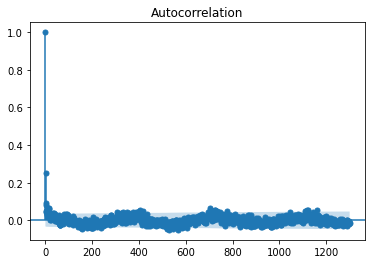

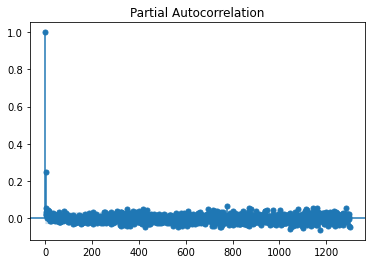

In [23]:
fig1=plot_acf(auser.Rainfall_Piaggione.loc[lastnan+dateoffset(1):],lags=1300)
fig2=plot_pacf(auser.Rainfall_Piaggione.loc[lastnan+dateoffset(1):],lags=1300)

it seems that seasonality has a very small effect and deseasonalizing won't make the task easier. An ARIMA(1,0,0) should work as well as a SARIMA with D=365

In [24]:
model=ARIMA(auser.Rainfall_Piaggione.loc[lastnan+dateoffset(1):],order=(1,0,0))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     Rainfall_Piaggione   No. Observations:                 3834
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -14626.659
Date:                Wed, 24 Aug 2022   AIC                          29259.318
Time:                        22:49:26   BIC                          29278.073
Sample:                    01-01-2010   HQIC                         29265.981
                         - 06-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1619      0.421      9.883      0.000       3.337       4.987
ar.L1          0.2517      0.009     26.706      0.000       0.233       0.270
sigma2       120.5526      1.189    101.418      0.000     118.223     122.882
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):            149465.39
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                             4.51
Prob(H) (two-sided):                  0.01   Kurtosis:                        32.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Interpretation:**
​
>by looking at the pvalue of the t-test (**P>|z|**), we deduce that the coefficients are significative and none should be removed
​

>the pvalue (**Prob(Q)**) of portemeanteau test indicates that autocorrelations of residual at all lags are nuls
​

>the pvalue (**Prob(H)**) of homoscedasticity test indicates that variance of residuals is not constant and changes severly over time, -we'll see this more clearly in the next graphs-
​

>the pvalue (**Prob(JB)**) of Jarque Bera test indicates that the distribution of residuals doesn't satisfy  normality hypothesis
​

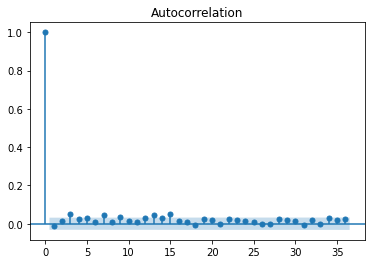

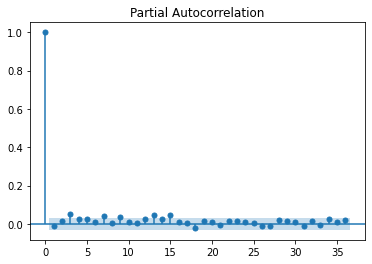

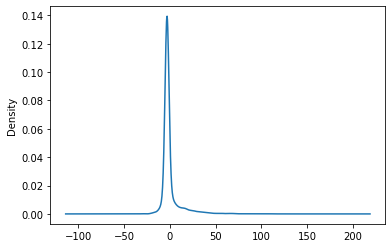

<AxesSubplot:xlabel='Date'>

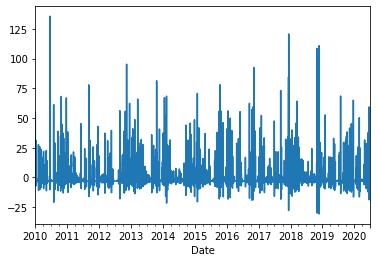

In [25]:
fig1=plot_acf(results.resid)
fig2=plot_pacf(results.resid)
plt.show()
results.resid.plot(kind='kde')
plt.show()
results.resid.plot()

The autocorrelation at the crucial lags--namely lags 1 has been eliminated, and there is no discernible pattern in higher-order lags, this gives the impression that the residual series looks to be white noise. But looking at the last graph , it clearly shows non constance of the variance which means the existance of volatility . one tool helps reducing the variance is the logarithmic or BoxCox transformation with adding a very small constant to the time series in order to avoid null values, but in our case, it does not help that much, because we obtain a bimodal distribution after the transformation (you can try it), which is not helpful at all.

The squared residuals series follows an ARMA pattern (see the ACF and PACF below ). This confirm what we've just said .


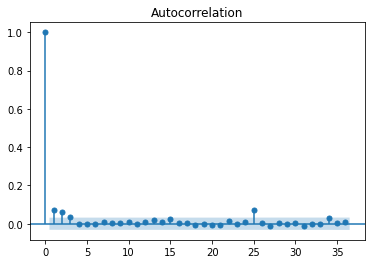

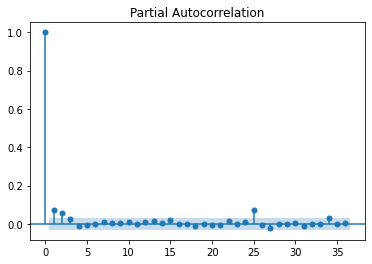

In [26]:
fig1=plot_acf((results.resid**2))
fig2=plot_pacf((results.resid**2))

Here you can see how poorly the model perform on train data :/

<AxesSubplot:xlabel='Date'>

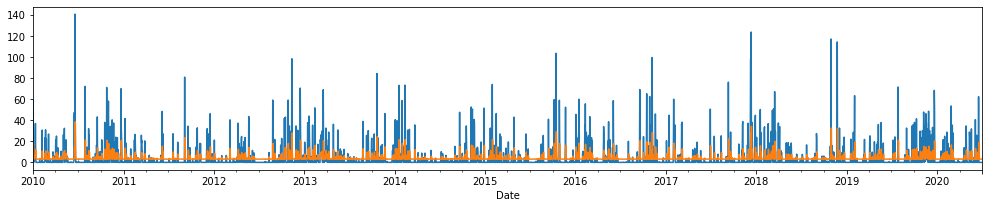

In [27]:
auser.Rainfall_Piaggione.loc[lastnan+dateoffset(1):].plot(figsize=(17,3))
results.fittedvalues.plot(figsize=(17,3))

### Other solution 

Without losing hope, we can take advantage of rainfall data of villages next to "Piaggione" , the  dataset contains 9 villages, using google map, we can see their locations in relation to "Piaggione", the nearest one is "Borgo_a_mozzano" with a distance of nearly 9Km. see the two encircled points in the photo

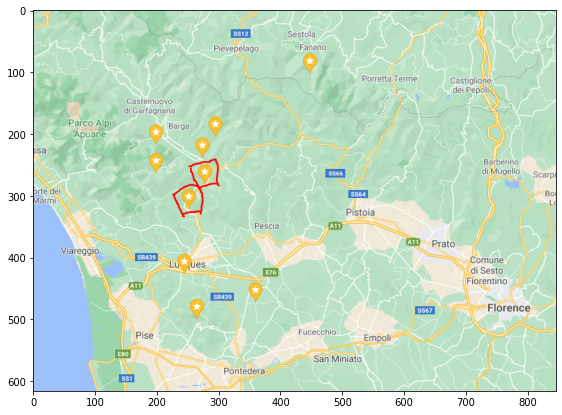

In [28]:
from matplotlib import image
image=image.imread("../input/villages-location/piaggione.PNG")
plt.figure(figsize = (20,7))
plt.imshow(image)
plt.show()

So these two villages should record almost the same precipitation data, by plotting the two series on the same figure, we hardly notice some differences on some spikes , but in general the series have the same behaviour. so this must be the best source to fill in with.

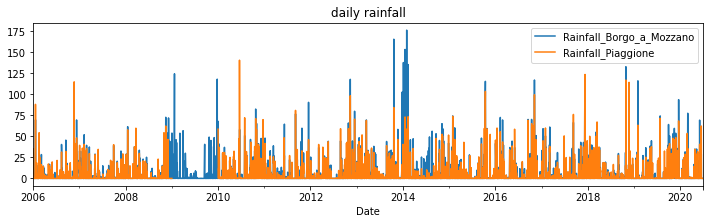

In [29]:
auser.plot(y=['Rainfall_Borgo_a_Mozzano','Rainfall_Piaggione'],figsize=(12,3),title='daily rainfall')

# fillin missing values
auser.Rainfall_Piaggione.loc[date(2009,1,1):date(2009,12,31)]=auser.Rainfall_Borgo_a_Mozzano.xs('2009').values

> ### **VAR3** : Depth_to_Groundwater_LT2

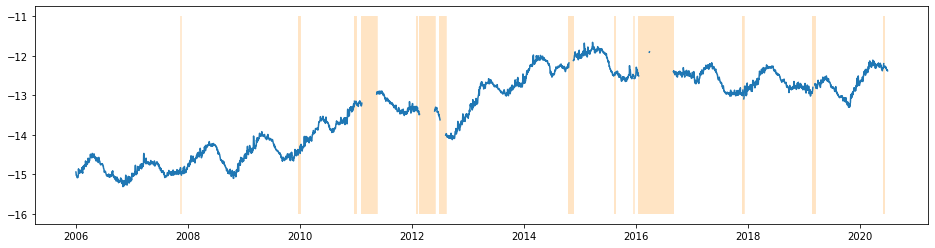

In [30]:
plt.figure(figsize=(16,4))
plt.plot(auser.Depth_to_Groundwater_LT2)

misses=auser.query('Depth_to_Groundwater_LT2!=Depth_to_Groundwater_LT2')
plt.vlines(misses.index,ymin=-16,ymax=-11,color='bisque')

this variable looks having a trendy behaviour with a yearly seasonality, a simple but a very strong model that can perfectly fit our data is the holt-winter additive model, to obtain accurate estimates, we will train the model on a first small chunk \[2006 to 2011\], then forecast only 1 future value, add this later to the chunk and retrain the model again, before each training step we check if the next value is missing or not, if not so no need to forecast, add the data to the chunk until the next missing point.

In [31]:
# function that fit data 
def frcast(data):
    expsmooth=ExponentialSmoothing(data,trend='add' ,seasonal='add',freq='D',seasonal_periods=364)
    model=expsmooth.fit()
    return model.forecast(1)
    

def fillin(featr,data):

    for i in tqdm(pd.date_range(start=date(2011,2,10),end=date(2020,6,30))):
        if pd.isnull(featr[str(i)]):
            data=data.append(frcast(data))
        else:
            data=data.append(featr[str(i):str(i)])
    return data

In [32]:

VAR3=auser.Depth_to_Groundwater_LT2[:str(date(2011,2,9))].copy()
VAR3.interpolate('slinear',inplace=True)
VAR3=fillin(auser.Depth_to_Groundwater_LT2,VAR3)

  0%|          | 0/3429 [00:00<?, ?it/s]

<AxesSubplot:xlabel='Date'>

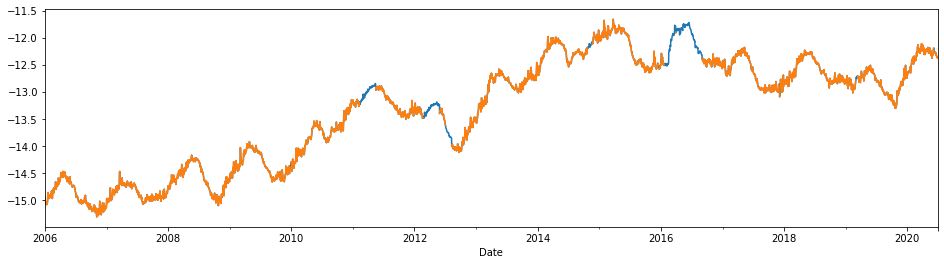

In [33]:
plt.figure(figsize=(16,4))
VAR3.plot()
auser.Depth_to_Groundwater_LT2.plot()

In [34]:
auser.Depth_to_Groundwater_LT2.fillna(VAR3)

Date
2006-01-01   -14.94
2006-01-02   -14.96
2006-01-03   -15.02
2006-01-04   -15.02
2006-01-05   -15.02
              ...  
2020-06-26   -12.36
2020-06-27   -12.36
2020-06-28   -12.37
2020-06-29   -12.36
2020-06-30   -12.38
Name: Depth_to_Groundwater_LT2, Length: 5295, dtype: float64

> ### **VAR4** : Depth_to_Groundwater_SAL

this variable is strongly volatil , and unfortunately the beginning part is missing, we'll use linear interpolation and mean imputation

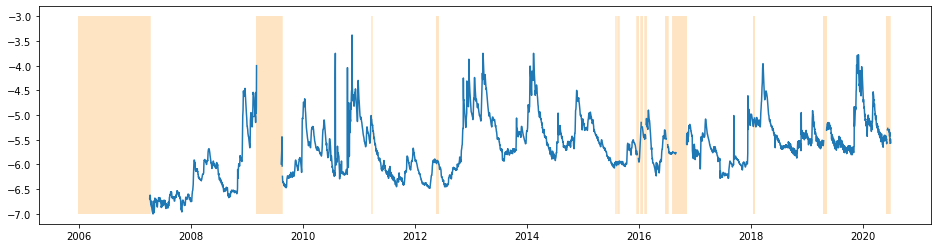

In [35]:
plt.figure(figsize=(16,4))
plt.plot(auser.Depth_to_Groundwater_SAL)
misses=auser.query('Depth_to_Groundwater_SAL!=Depth_to_Groundwater_SAL')
plt.vlines(misses.index,ymin=-7,ymax=-3,color='bisque')

In [36]:
auser.Depth_to_Groundwater_SAL.interpolate('slinear',inplace=True)
auser.Depth_to_Groundwater_SAL.fillna(auser.Depth_to_Groundwater_SAL.mean(),inplace=True)

> ### **VAR5** : Depth_to_Groundwater_DAG

this variable has a clear yearly seasonality and low variance(no trend), but full of holes and the beginning part is missing, so we can not use holt-winter model,  the best way to impute is using seasonal average

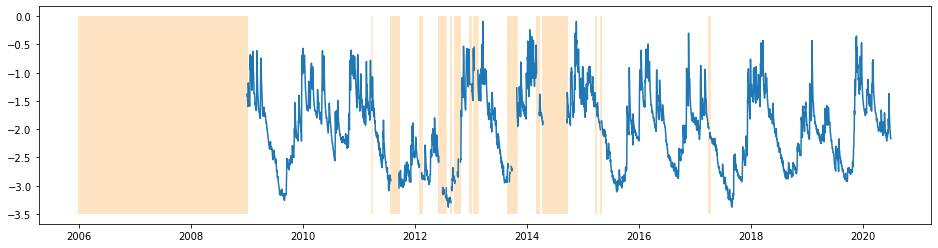

In [37]:
plt.figure(figsize=(16,4))
plt.plot(auser.Depth_to_Groundwater_PAG)
misses=auser.query('Depth_to_Groundwater_PAG!=Depth_to_Groundwater_PAG')
plt.vlines(misses.index,ymin=-3.5,ymax=0,color='bisque')

In [38]:
# aggregate the mean over the day of year 
pagmean=auser.Depth_to_Groundwater_PAG.groupby(auser.index.dayofyear).mean()
#set the same index of the mean to make the join
auser.set_index(auser.index.dayofyear,append=True,inplace=True)

<AxesSubplot:xlabel='Date'>

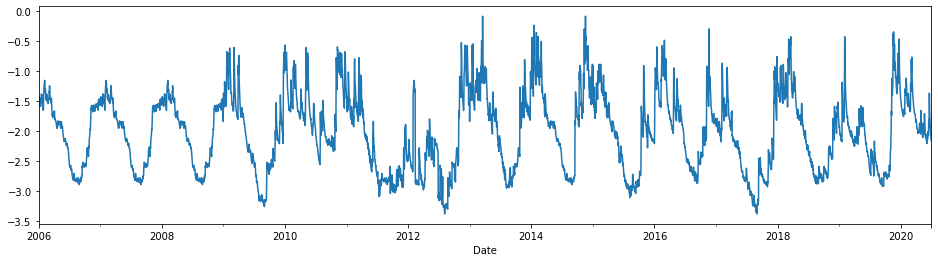

In [39]:
#fillna with the mean and reser index
auser.reset_index(level=0,inplace=True)
auser.Depth_to_Groundwater_PAG.fillna(pagmean,inplace=True)
auser.index.rename('dayofyear',inplace=True)
auser.set_index('Date',drop=True,inplace=True)
plt.figure(figsize=(16,4))
auser.Depth_to_Groundwater_PAG.plot()

<br>
<br>

#### **We'll use the same technique for the rest of variables since they share the same properties**

> ### **VAR6** : Depth_to_Groundwater_CoS

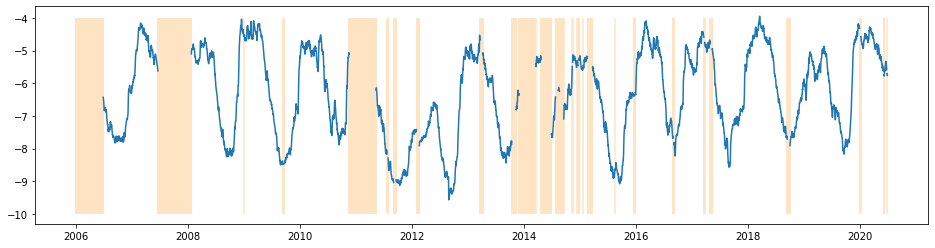

In [40]:
plt.figure(figsize=(16,4))
plt.plot(auser.Depth_to_Groundwater_CoS)
misses=auser.query('Depth_to_Groundwater_CoS!=Depth_to_Groundwater_CoS')
plt.vlines(misses.index,ymin=-10,ymax=-4,color='bisque')

<AxesSubplot:xlabel='Date'>

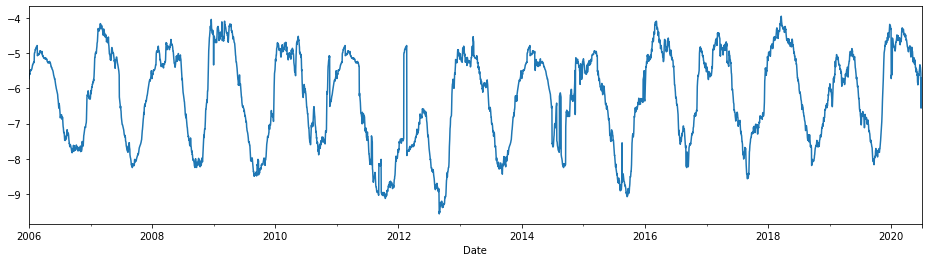

In [41]:
# aggregate the mean over the day of year 
cosmean=auser.Depth_to_Groundwater_CoS.groupby(auser.index.dayofyear).mean()

#set the same index of the mean to make the join
auser.set_index(auser.index.dayofyear,append=True,inplace=True)

#fillna with the mean and reset index
auser.reset_index(level=0,inplace=True)
auser.Depth_to_Groundwater_CoS.fillna(cosmean,inplace=True)
auser.index.rename('dayofyear',inplace=True)
auser.set_index('Date',drop=True,inplace=True)
plt.figure(figsize=(16,4))
auser.Depth_to_Groundwater_CoS.plot()

> ### **VAR7** : Depth_to_Groundwater_DIEC

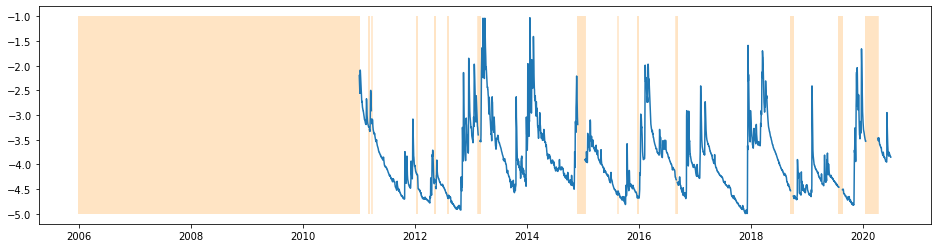

In [42]:
plt.figure(figsize=(16,4))
plt.plot(auser.Depth_to_Groundwater_DIEC)
misses=auser.query('Depth_to_Groundwater_DIEC!=Depth_to_Groundwater_DIEC')
plt.vlines(misses.index,ymin=-5,ymax=-1,color='bisque')

<AxesSubplot:xlabel='Date'>

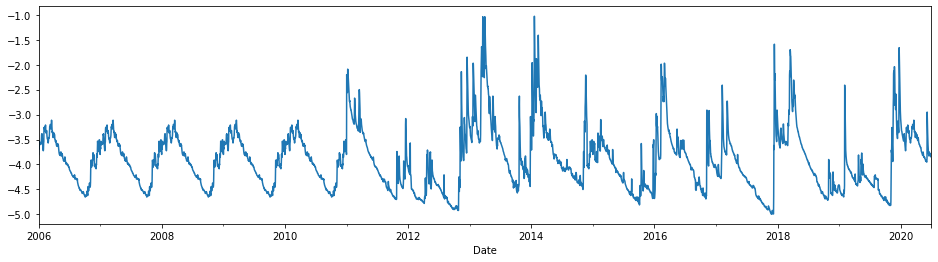

In [43]:
# aggregate the mean over the day of year 
diecmean=auser.Depth_to_Groundwater_DIEC.groupby(auser.index.dayofyear).mean()

#set the same index of the mean to make the join
auser.set_index(auser.index.dayofyear,append=True,inplace=True)

#fillna with the mean and reser index
auser.reset_index(level=0,inplace=True)
auser.Depth_to_Groundwater_DIEC.fillna(diecmean,inplace=True)
auser.index.rename('dayofyear',inplace=True)
auser.set_index('Date',drop=True,inplace=True)
plt.figure(figsize=(16,4))
auser.Depth_to_Groundwater_DIEC.plot()

> ### **VAR8** : Hydrometry_Monte_S_Quirico

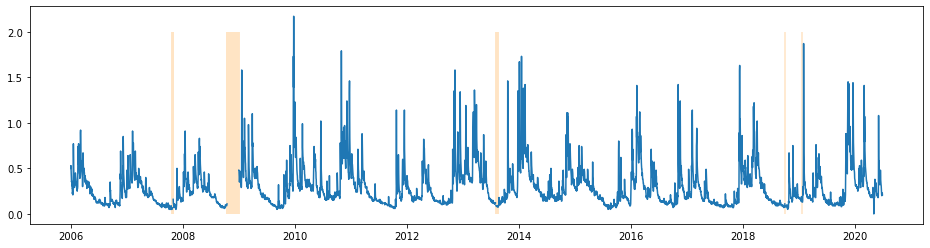

In [44]:
plt.figure(figsize=(16,4))
plt.plot(auser.Hydrometry_Monte_S_Quirico)
misses=auser.query('Hydrometry_Monte_S_Quirico!=Hydrometry_Monte_S_Quirico')
plt.vlines(misses.index,ymin=0,ymax=2,color='bisque')

<AxesSubplot:xlabel='Date'>

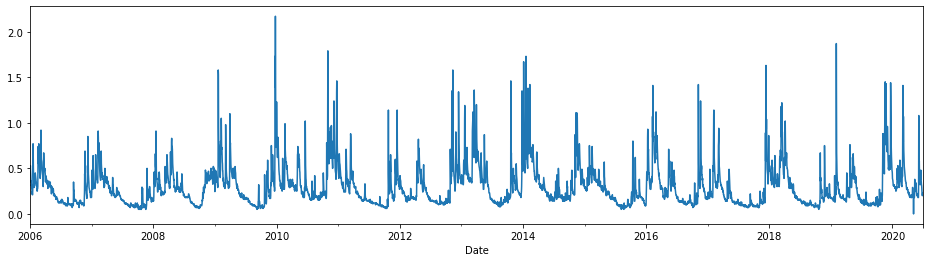

In [45]:
# aggregate the mean over the day of year 
montemean=auser.Hydrometry_Monte_S_Quirico.groupby(auser.index.dayofyear).mean()

#set the same index of the mean to make the join
auser.set_index(auser.index.dayofyear,append=True,inplace=True)

#fillna with the mean and reser index
auser.reset_index(level=0,inplace=True)
auser.Hydrometry_Monte_S_Quirico.fillna(montemean,inplace=True)
auser.index.rename('dayofyear',inplace=True)
auser.set_index('Date',drop=True,inplace=True)
plt.figure(figsize=(16,4))
auser.Hydrometry_Monte_S_Quirico.plot()

> ### **VAR9** : Hydrometry_Piaggione

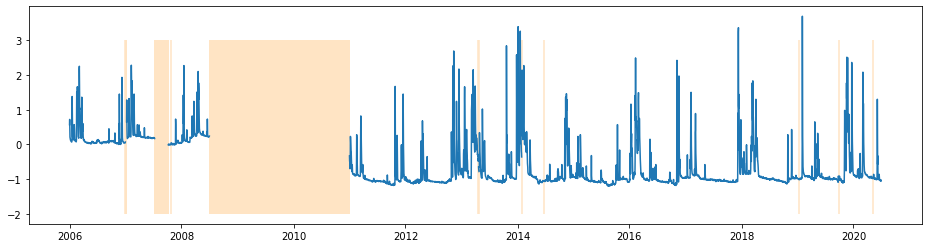

In [46]:
plt.figure(figsize=(16,4))
plt.plot(auser.Hydrometry_Piaggione)
misses=auser.query('Hydrometry_Piaggione!=Hydrometry_Piaggione')
plt.vlines(misses.index,ymin=-2,ymax=3,color='bisque')

Now for this last variable we may think that there is a data entry error, but according to the [data description](https://www.kaggle.com/c/acea-water-prediction/data?select=datasets_description.xlsx), this variable can take both positive and negative values.

<AxesSubplot:xlabel='Date'>

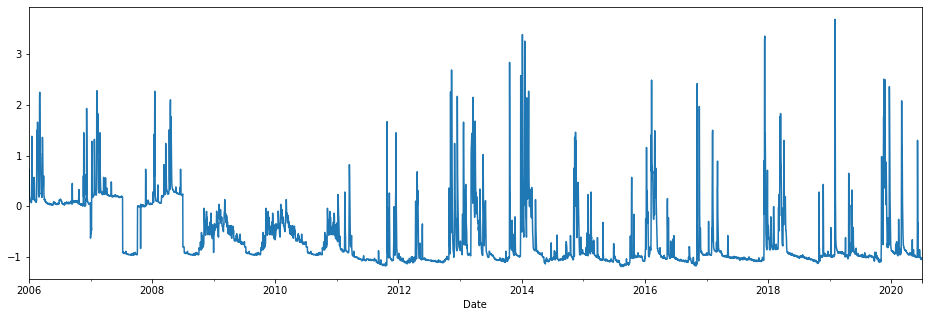

In [47]:
# aggregate the mean over the day of year 
hydropiag=auser.Hydrometry_Piaggione.groupby(auser.index.dayofyear).mean()

#set the same index of the mean to make the join
auser.set_index(auser.index.dayofyear,append=True,inplace=True)

#fillna with the mean and reser index
auser.reset_index(level=0,inplace=True)
auser.Hydrometry_Piaggione.fillna(hydropiag,inplace=True)
auser.index.rename('dayofyear',inplace=True)
auser.set_index('Date',drop=True,inplace=True)
plt.figure(figsize=(16,5))
auser.Hydrometry_Piaggione.plot()

<br>

<br>

Now that the dataset is cleaned and ready to use, you can start training !